-----------------
# Exploratory Analysis of Major Stock Market Indices
-----------------
To retreive data please use yahoo finance and the ticker symbol for each index.
- Data Source: https://finance.yahoo.com/

The goal is to show you the performance of S&P for the last 5 years in terms of price, returns, and the distribution of both of these attributes. Finally there is a comparison between major indices with a brief explanation on their relative performance.


In [32]:
import pandas as pd
import numpy as np
import math as ma
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

In [33]:
# Read in the dataset and set the index as date
spy = pd.read_csv('sp500.csv', parse_dates = ['Date'], index_col='Date')

# inspect the dataframe and check for the presence of null values
print(spy.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1272 entries, 2015-01-02 to 2020-01-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1272 non-null   float64
 1   High       1272 non-null   float64
 2   Low        1272 non-null   float64
 3   Close      1272 non-null   float64
 4   Adj Close  1272 non-null   float64
 5   Volume     1272 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.6 KB
None


The adjusted close price for the index is selected and the price is plotted to observe the performance of the index 2015 - 2020. The most notable dip is for December 2018.

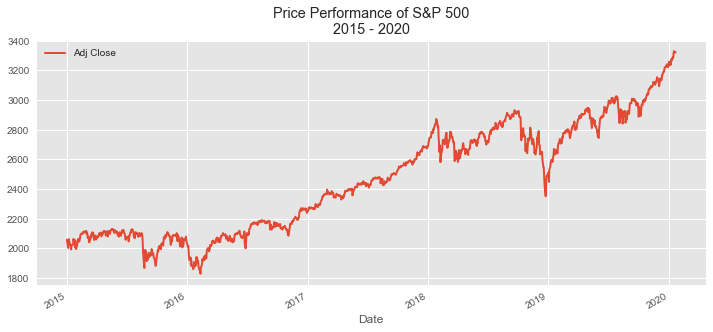

In [35]:
spy = spy.loc[:,['Adj Close']]
spy = spy.sort_values('Date')
ax = spy.plot(grid=True,figsize=(12,5), linewidth=2)
ax.set_title('Price Performance of S&P 500\n2015 - 2020')
plt.style.use('seaborn-dark')
plt.style.use('ggplot')
plt.show()

After resampleing the dataset with a daily requency we have 575 null values. These null values are replaced with interpolated values to create a consistent dataframe.

Null Values:  Adj Close    575
dtype: int64


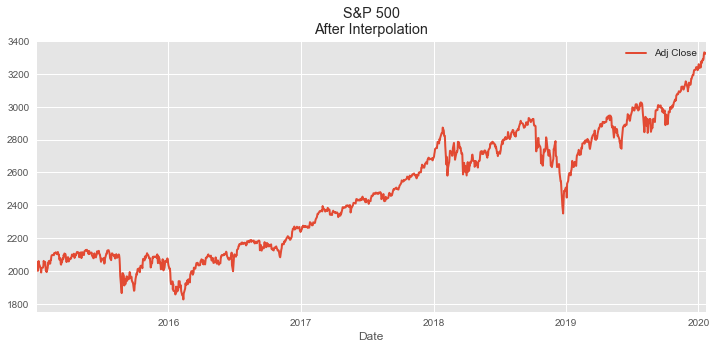

In [36]:
# resample the dataframe and check for null values
spy = spy.resample('D').asfreq()
print('Null Values: ', spy.isnull().sum())

#replace nan with interpolated values
spy = spy.interpolate()
ax = spy.plot(figsize=(12,5), linewidth=2, grid=True)
plt.title('S&P 500\nAfter Interpolation')
plt.style.use('seaborn-dark')
plt.show()

From the previous plots the S&P shows a clear increasing trend in price which implies that the data is not stationary. For many time series models one of the important assumptions is that the data must be stationary. This is possible by differencing the series using fixed intervals. In this case we use a difference of 1 which is also the percentage change or daily return between prices. After differencing the series we conduct the Augmented Dicky Fuller Test to see if the p-value produced by the test is significant at an alpha of 0.05. 

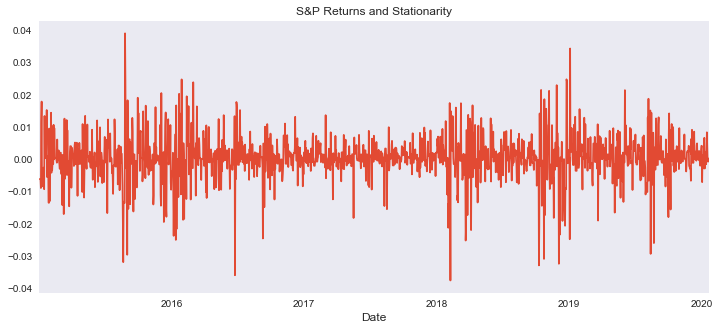

Percentage change between prices show stationarity with the Augmented Dicky Fuller test producing a p-value of  2.0452127997323423e-30  which is significant at level 0.05.
AVG Daily Return:  0.028


In [37]:
ax = spy['Adj Close'].pct_change(1).plot(figsize=(12,5))
plt.style.use('seaborn-dark')
plt.style.use('seaborn')
plt.title('S&P Returns and Stationarity')
plt.show()

#test for stationarity
stat = adfuller(spy['Adj Close'].pct_change().dropna())
print('Percentage change between prices show stationarity with the Augmented Dicky Fuller test producing a p-value of ',stat[1], ' which is significant at level 0.05.')

returns = spy['Adj Close'].pct_change()*100
returns = returns.dropna()
print('AVG Daily Return: ', round(returns.mean(),4))

The differenced series above is stationary and can be used for modeling.

In the following lines of code the price performance of S&P 500 is plotted again along with a 30 day and a 60 day moving average of index value. A box plot showing the variation of index is plotted, and density plots showing the distribution of prices and returns for the index are plotted using density plots. The density plots show that returns are significanlty more symmetrical than the price of the index.

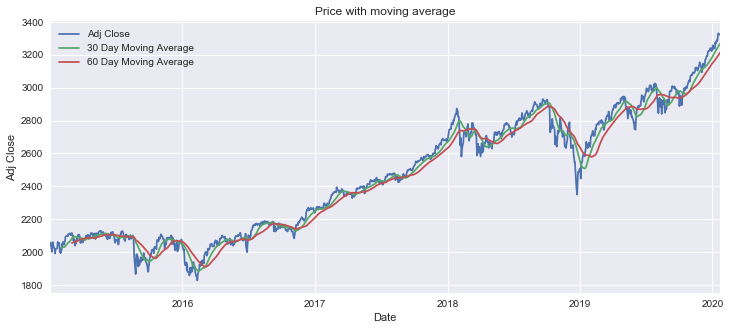

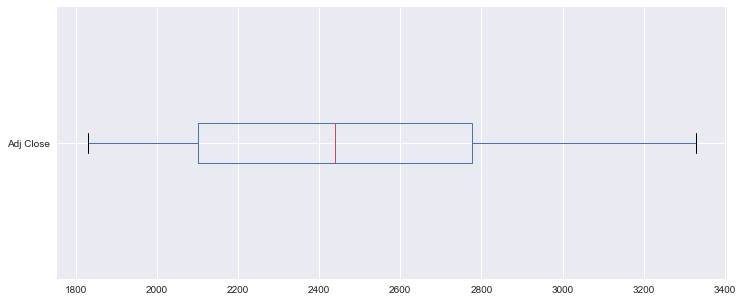

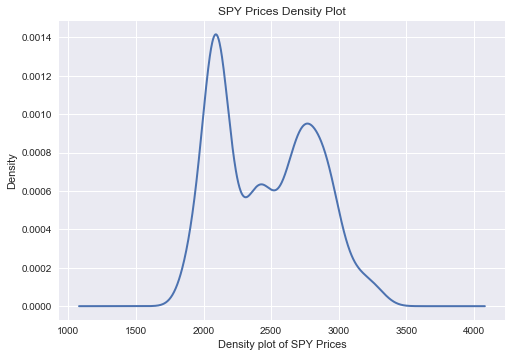

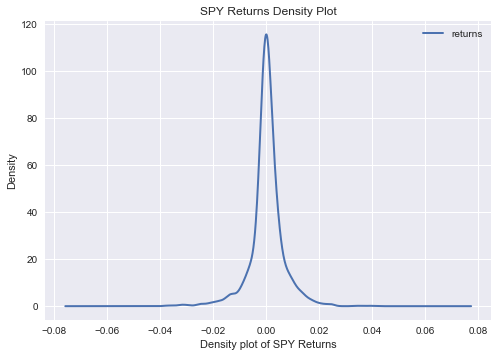

In [38]:
import warnings 
warnings.simplefilter('ignore')

#Plot Aggregates using moving average
spy['30 Day Moving Average'] = spy['Adj Close'].rolling(window=30).mean()
spy['60 Day Moving Average'] = spy['Adj Close'].rolling(window=60).mean()
ax = spy.plot(figsize=(12,5))
ax.set_xlabel('Date')
ax.set_ylabel('Adj Close')
ax.set_title('Price with moving average')
plt.show()


ax = spy[['Adj Close']].boxplot(vert=False,figsize=(12,5))
plt.show()

#density plots are better in that they can show where most of the data is concentrated
spy_dist = spy.iloc[:,[0]]
spy_dist['returns'] = spy['Adj Close'].pct_change().dropna()
ax = spy_dist['Adj Close'].plot(kind='density', linewidth=2)
ax.set_xlabel('Density plot of SPY Prices')
ax.set_title('SPY Prices Density Plot')
plt.show()

ax = spy_dist[['returns']].dropna().plot(kind='density', linewidth=2)
ax.set_xlabel('Density plot of SPY Returns')
ax.set_title('SPY Returns Density Plot')
plt.show()

After performing simple aggregation on the data by monthly averages for the past 5 years we see that the S&P on average has dropped in February with the rest of the months showing an increasing trend.

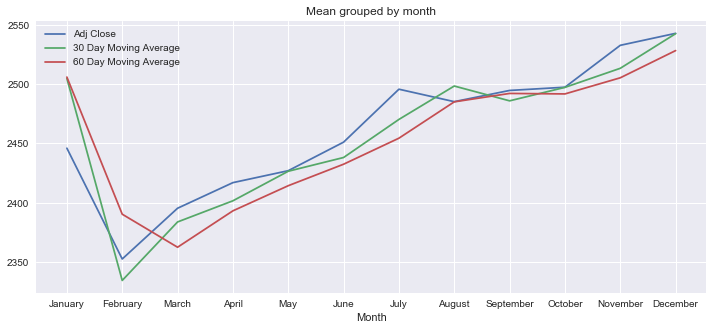

           Adj Close  30 Day Moving Average  60 Day Moving Average
month                                                             
January       2446.0                 2504.8                 2506.0
February      2352.6                 2334.5                 2390.4
March         2395.4                 2383.8                 2362.5
April         2417.0                 2401.7                 2393.2
May           2427.0                 2426.6                 2414.4
June          2451.1                 2438.2                 2432.5
July          2495.7                 2470.3                 2454.4
August        2485.2                 2498.4                 2485.1
September     2494.7                 2485.9                 2492.2
October       2497.4                 2497.3                 2491.8
November      2532.7                 2513.3                 2505.3
December      2542.8                 2542.5                 2528.3


In [39]:
#Group data by month and day to get means
spy_by_month = spy.groupby(spy.index.month_name()).mean()
month = ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

spy_by_month['month'] = pd.Categorical(spy_by_month.index, categories=month, ordered=True)
spy_by_month = spy_by_month.set_index('month').sort_values('month')

ax = spy_by_month.plot(figsize=(12,5))
ax.set_xlabel('Month')
plt.xticks(range(0,len(spy_by_month.index)), spy_by_month.index)
plt.title('Mean grouped by month')
plt.show()

print(round(spy_by_month,1))

-----------
# More indices and relative performance
----------
Indices:
 - Nasdaq
 - S&P
 - ibovespa
 - HSI
 - 10 year bond yields

In [40]:
# Read in more index values
nasdaq = pd.read_csv('nasdaq.csv', parse_dates=['Date'], index_col='Date')
sp = pd.read_csv('sp500.csv', parse_dates=['Date'], index_col='Date')
ib = pd.read_csv('ibovespa.csv', parse_dates=['Date'], index_col='Date')
hs = pd.read_csv('hsi.csv', parse_dates=['Date'], index_col='Date')
tn = pd.read_csv('tnx.csv', parse_dates=['Date'], index_col='Date')

# Select adjusted close
ndq = nasdaq.iloc[:,[4]]
spy = sp.iloc[:,[4]]
ibp = ib.iloc[:,[4]]
hsi = hs.iloc[:,[4]]
tnx = tn.iloc[:,[4]]

Data for the above mentioned indices is read and a dataframe is created which combines all indices. Using the first value for each index the entire dataframe is normalized with respect to each index value. This allows to observe the relative performance of these indices using the same scale. From the plot we see that all indices follow the same increasing trend until the drop of December 2018 after which there is a divergence and the S&P, Nasdaq, and iBovespa gain significantly more than 10 year bond yields and the HSI index. One explanation for this could be the inflow of funds into 10 year bonds which caused the yields to drop resulting to rising prices, slow GDP growth prospects for China and Hong Kong(Chinese special administrative region), and inflow of funds in the western equity markets.  

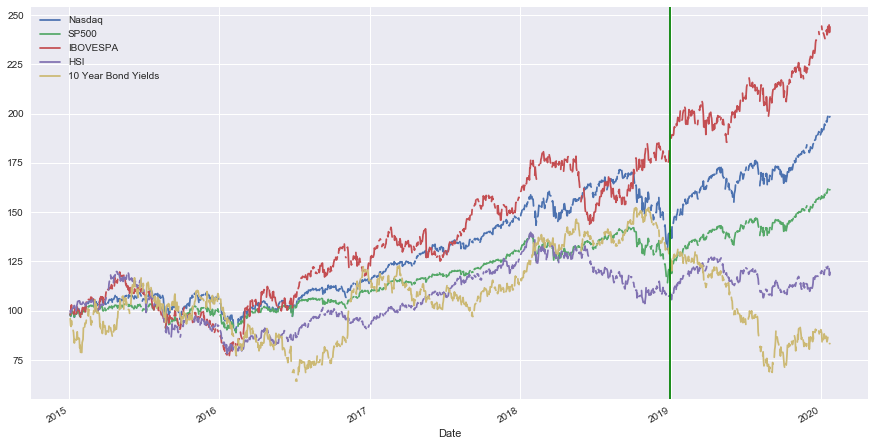

In [41]:
# rename each dataframe pertaining to the index it represents 
ndq = ndq.rename(columns = {'Adj Close': 'Nasdaq',
                            'Volume':'Nasdaq Volume'})
spy = spy.rename(columns = {'Adj Close': 'SP500',
                            'Volume':'SP500 Volume'})
ibp = ibp.rename(columns = {'Adj Close': 'IBOVESPA',
                          'Volume': 'IBOVESPA Volume'})
hsi = hsi.rename(columns = {'Adj Close': 'HSI',
                           'Volume': 'HSI Volume'})
tnx = tnx.rename(columns = {'Adj Close': '10 Year Bond Yields',
                           'Volume': '10 Year Bond Volume'})

# concat all indices using the date index
indices = pd.concat([ndq, spy, ibp, hsi, tnx], axis=1)

#Select the first value for each index
first_price = indices.iloc[0]

#normalize the index using the first value and plot relative performance
normalized = indices.div(first_price).mul(100)

ax = normalized.plot(figsize=(15,8))
ax.axvline('2018-12-31', color='green')
plt.show()